# 0. Начало

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import integrate

DEFAULT_EMISSIONS = np.array([0.7, 0.3, 0.05])
STATE_NAMES = ["живое", "полуживое", "мертвое"]
STATE_COLORS = ["tab:green", "tab:orange", "tab:gray"]
N = 50
seed = 42
cmap_states = ListedColormap(STATE_COLORS)

# 1. Вспомогательные функции

In [2]:
def neighbor_mask(n_states=3):
    M = np.zeros((n_states, n_states), dtype=bool)
    for i in range(n_states):
        for j in (i-1, i, i+1):
            if 0 <= j < n_states:
                M[i, j] = True
    return M

def masked_dirichlet_row(rng, alpha_row, mask_row):
    allowed_idx = np.flatnonzero(mask_row)
    alpha_allowed = np.asarray(alpha_row)[allowed_idx]
    sampled = rng.dirichlet(alpha_allowed)
    row = np.zeros_like(mask_row, dtype=float)
    row[allowed_idx] = sampled
    return row

def normalize_rows(mat):
    mat = np.array(mat, dtype=float)
    row_sums = mat.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0 # чтобы избежать деления на 0 (строка нулей останется нулевой)
    return mat / row_sums

In [3]:
def plot_sequence(states, obs, title):
    T = len(states)
    fig, axes = plt.subplots(2, 1, figsize=(12, 3.5), sharex=True, gridspec_kw={'height_ratios': [1, 0.6]})

    axes[0].scatter(np.arange(T), states, c=states, cmap=cmap_states, s=12)
    axes[0].set_yticks([0,1,2])
    axes[0].set_yticklabels(STATE_NAMES)
    axes[0].set_ylabel("hidden state")
    axes[0].set_title(title)
    
    axes[1].plot(obs, drawstyle='steps-mid', marker='o', markersize=3)
    axes[1].set_yticks([0,1])
    axes[1].set_yticklabels(["0","1"])
    axes[1].set_ylabel("visited")
    axes[1].set_xlabel("time")
    plt.tight_layout()
    plt.show()

def plot_intensity_and_visits(t_cont, lam_cont, visits_days, title):
    days = len(visits_days)
    fig, ax1 = plt.subplots(figsize=(12,3.5))
    ax1.plot(t_cont, lam_cont, label="lambda(t)", lw=2)
    ax1.set_ylabel("intensity λ(t)")
    ax1.set_xlabel("time (days)")
    ax1.set_title(title)
   
    visit_times = np.where(visits_days==1)[0] + 0.5
    if len(visit_times) > 0:
        ax1.scatter(visit_times, np.interp(visit_times, t_cont, lam_cont),
                    marker='*', s=200, c="red",label="visit (>=1 event that day)")
    ax1.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# 2. Сэмплирование по марковским цепям

In [ ]:
def sample_fixed(sample_size, P=None, emissions=DEFAULT_EMISSIONS, neighbor_only=True):
    rng = np.random.default_rng(seed)
    n_states = len(emissions)
    if neighbor_only:
        mask = neighbor_mask(n_states)
        if P is None:
            P_used = np.array([normalize_rows(np.atleast_2d(mask[i].astype(float)))[0] for i in range(n_states)]) # равномерно
        else:
            tmp = np.array(P, dtype=float) * mask
            P_used = normalize_rows(tmp)
    else:
        if P is None:
            P_used = np.ones((n_states, n_states)) / n_states
        else:
            P_used = normalize_rows(P)
    
    state = rng.integers(0, n_states)
    states = np.empty(sample_size, dtype=int)
    obs = np.empty(sample_size, dtype=int)
    for t in range(sample_size):
        states[t] = state
        obs[t] = rng.random() < emissions[state] # 1 - посещение, 0 - нет
        state = rng.choice(n_states, p=P_used[state])
    return states, obs, P_used

In [ ]:
def sample_dirichlet(sample_size, alpha=None, emissions=DEFAULT_EMISSIONS, neighbor_only=True):
    rng = np.random.default_rng(seed)
    n_states = len(emissions)
    mask = neighbor_mask(n_states) if neighbor_only else np.ones((n_states, n_states), dtype=bool)
    
    if alpha is None:
        alpha_mat = np.ones((n_states, n_states))
    else:
        alpha_mat = np.array(alpha)
        if alpha_mat.ndim == 1:
            alpha_mat = np.tile(alpha_mat, (n_states, 1))
    
    P_sampled = np.zeros((n_states, n_states))
    for i in range(n_states):
        P_sampled[i] = masked_dirichlet_row(rng, alpha_mat[i], mask[i])
    
    state = rng.integers(0, n_states)
    states = np.empty(sample_size, dtype=int)
    obs = np.empty(sample_size, dtype=int)
    for t in range(sample_size):
        states[t] = state
        obs[t] = rng.random() < emissions[state]
        state = rng.choice(n_states, p=P_sampled[state])
    return states, obs, P_sampled

In [6]:
def sample_period_dirichlet(sample_size, P=None, emissions=DEFAULT_EMISSIONS, alpha=None, neighbor_only=True):
    rng = np.random.default_rng(seed)
    n_states = len(emissions)
    mask = neighbor_mask(n_states) if neighbor_only else np.ones((n_states, n_states), dtype=bool)
    if alpha is None:
        if P is not None:
            alpha_mat = np.array(P, dtype=float)
        else:
            alpha_mat = np.ones((n_states, n_states))
    else:
        alpha_mat = np.array(alpha)
        if alpha_mat.ndim == 1:
            alpha_mat = np.tile(alpha_mat, (n_states, 1))
    states = np.empty(sample_size, dtype=int)
    obs = np.empty(sample_size, dtype=int)
    P_ts = np.zeros((sample_size, n_states, n_states))
    state = rng.integers(0, n_states)
    for t in range(sample_size):
        P_t = np.zeros((n_states, n_states))
        for i in range(n_states):
            P_t[i] = masked_dirichlet_row(rng, alpha_mat[i], mask[i])
        P_ts[t] = P_t
        states[t] = state
        obs[t] = rng.random() < emissions[state]
        state = rng.choice(n_states, p=P_t[state])
    return states, obs, P_ts

## 2.1. Результаты

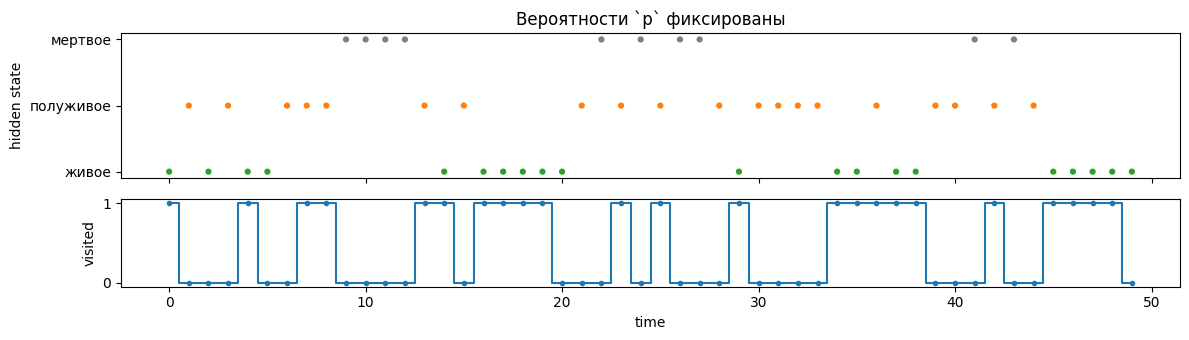

In [7]:
s1, o1, P1 = sample_fixed(N, neighbor_only=True)
plot_sequence(s1, o1, "Вероятности `p` фиксированы")

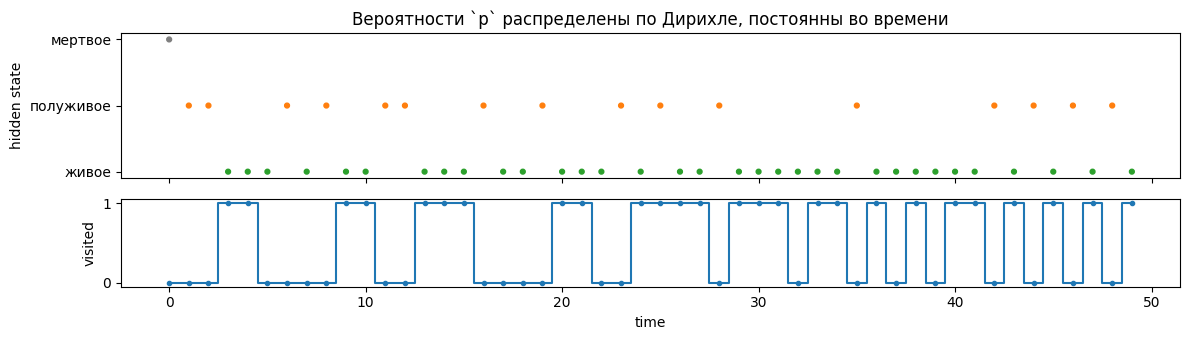

In [20]:
s2, o2, P2 = sample_dirichlet(N, neighbor_only=True)
plot_sequence(s2, o2, "Вероятности `p` распределены по Дирихле, постоянны во времени")

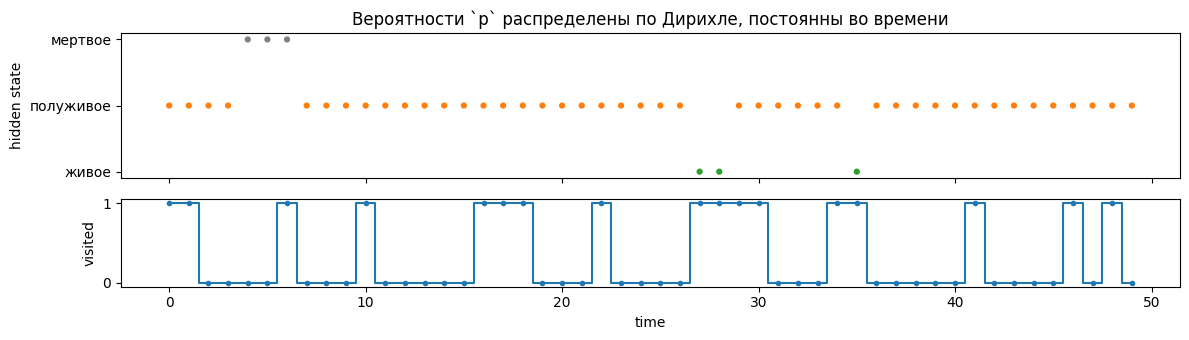

In [18]:
s2, o2, P2 = sample_dirichlet(N, neighbor_only=True, alpha=[0.9, 0.9, 0.9])
plot_sequence(s2, o2, "Вероятности `p` распределены по Дирихле, постоянны во времени")

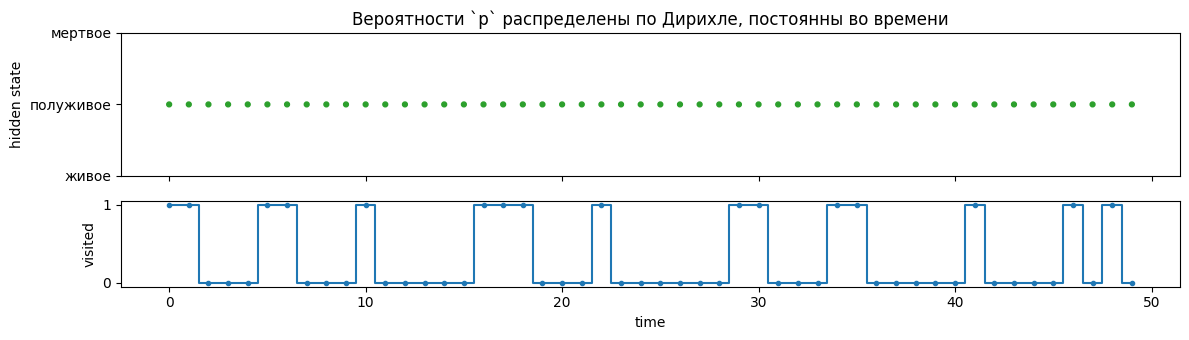

In [19]:
s2, o2, P2 = sample_dirichlet(N, neighbor_only=True, alpha=[0.1, 0.1, 0.1])
plot_sequence(s2, o2, "Вероятности `p` распределены по Дирихле, постоянны во времени")

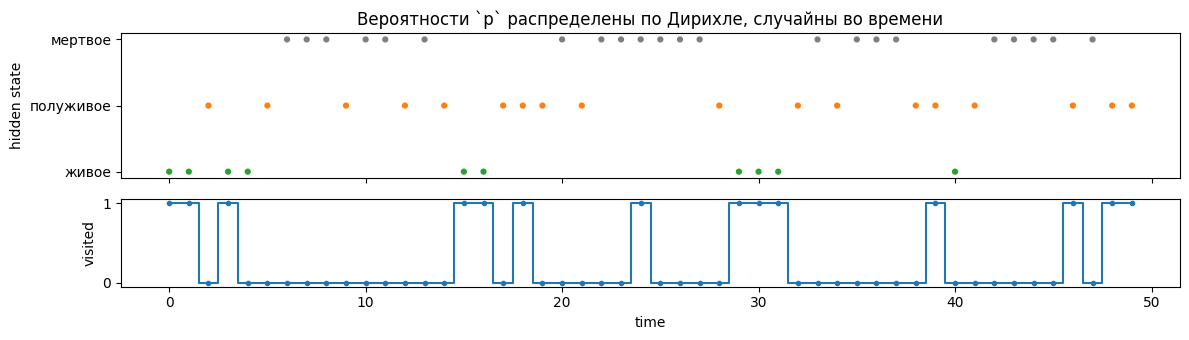

In [9]:
s3, o3, Pts = sample_period_dirichlet(N, neighbor_only=True)
plot_sequence(s3, o3, "Вероятности `p` распределены по Дирихле, случайны во времени")

# 3. Сэмплирование по Пуассону

In [10]:
def sample_poisson_process(lam, days):
    rng = np.random.default_rng(seed)
    counts = rng.poisson(lam, size=days)
    visits = (counts > 0).astype(int)
    cumulative = np.cumsum(counts)
    return visits, counts, cumulative

In [11]:
def sample_poisson_flow(lambda_func, days, method='quad', n_grid=1000):
    rng = np.random.default_rng(seed)
    if method == 'quad':
        lambda_days = np.zeros(days)
        for d in range(days):
            val, _ = integrate.quad(lambda_func, d, d+1)
            lambda_days[d] = max(val, 0.0)
        t_cont = np.linspace(0, days, max(500, days*10))
        lam_cont = np.array([lambda_func(t) for t in t_cont])
    else:
        t_grid = np.linspace(0, days, n_grid*days + 1)
        lam_grid = np.array([lambda_func(t) for t in t_grid])
        lambda_days = np.zeros(days)
        pts_per_day = n_grid
        for d in range(days):
            start = d * pts_per_day
            end = (d+1) * pts_per_day + 1
            lambda_days[d] = np.trapz(lam_grid[start:end], t_grid[start:end])
        t_cont, lam_cont = t_grid, lam_grid

    counts = rng.poisson(lambda_days)
    visits = (counts > 0).astype(int)
    cumulative = np.cumsum(counts)
    return visits, counts, cumulative, lambda_days, (t_cont, lam_cont)

## 3.1. Результаты

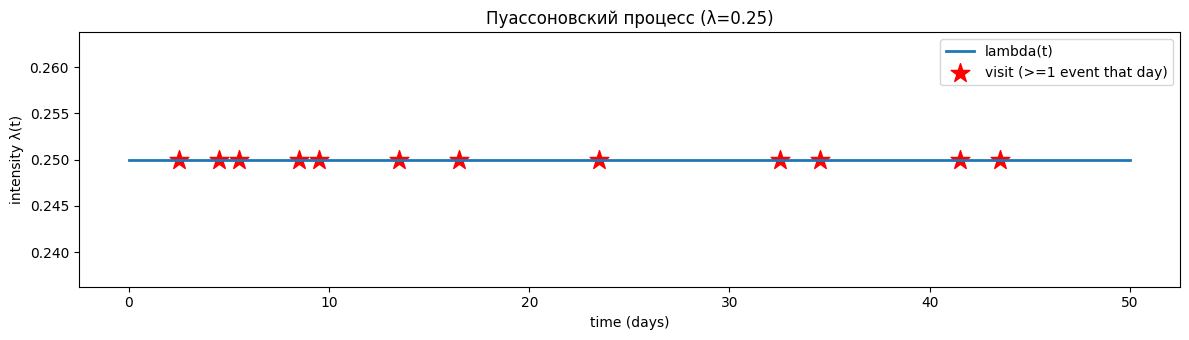

In [12]:
lam_const = 0.25
v1, counts1, cum1 = sample_poisson_process(lam_const, N)
t_cont = np.linspace(0, N, 500)
lam_cont_const = np.full_like(t_cont, lam_const)

plot_intensity_and_visits(t_cont, lam_cont_const, v1, f"Пуассоновский процесс (λ={lam_const})")

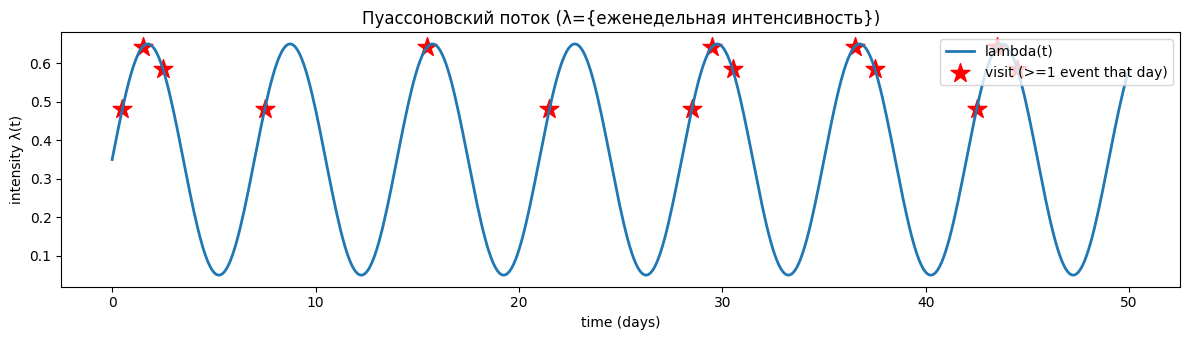

In [13]:
def lambda_periodic(t):
    return 0.05 + 0.6 * (0.5 * (1 + np.sin(2 * np.pi * t / 7))) # weekly periodic intensity

v2, counts2, cum2, lambda_days, (t_cont2, lam_cont2) = sample_poisson_flow(lambda_periodic, N, method='quad')

plot_intensity_and_visits(t_cont2, lam_cont2, v2, "Пуассоновский поток (λ={еженедельная интенсивность})")